In [ ]:
# default_exp predict

# Predict
> Functions to get model predictions for the high resolution burned area maps.

In [ ]:
#hide
from nbdev.export import notebook2script

In [ ]:
#export
import numpy as np
import pandas as pd
import torch
import rasterio
import matplotlib.pyplot as plt
from pathlib import Path
from fastprogress import progress_bar
from banet.predict import image2tiles, tiles2image
from rasterio.crs import CRS
from fire_split.core import split_fires, save_data, to_polygon
from FireHR.data import download_data, RegionST, get_event_data
from FireHR.models import *

In [ ]:
#export
def get_preds(im, thr=0.5, tile_size=2048, tile_step=2000, max_image_size=2048, 
              coarse_mask_expansion_size=101, gpu=True):
    if not gpu: max_image_size=10000
    image_size = im.shape[:2]
    if max(image_size) < max_image_size:
        im = torch.from_numpy(im)[None].permute(0,3,1,2).float()
    else:
        im = torch.from_numpy(
            image2tiles(im, step=tile_step, size=tile_size)).permute(0,3,1,2).float()
    model = load_pretrained_model(gpu=gpu)
    outs = []
    print('Generating model predicitons...')
    with torch.no_grad():
        for im0 in progress_bar(im):
            im0 = im0[None]
            im0 = expand_filter(im0, ks=coarse_mask_expansion_size)
            if gpu:
                out = model(im0.half().cuda()).squeeze().sigmoid()
            else:
                out = model(im0).squeeze().sigmoid()
            out = out.cpu().numpy()
            outs.append(out)

    outs = np.array(outs)
    if max(image_size) > max_image_size:
        out = tiles2image(outs, image_size, size=tile_size, step=tile_step)
    else: out = outs.squeeze().astype(np.float32)
    out[out<thr] = 0
    return out

Event time_start: 2020-05-06 00:00:00
Event time_end: 2020-09-11 00:00:00
Generating model predicitons...


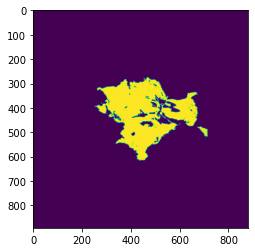

In [ ]:
#local
im, transform, crs = get_event_data('temp', 2020, 'temp/banet100m.tif')
preds = get_preds(im)
plt.imshow(preds);

In [ ]:
#hide
notebook2script()

Converted 01_data.ipynb.
Converted 02_models.ipynb.
Converted 03_predict.ipynb.
Converted 04_cli.ipynb.
Converted index.ipynb.
